На этом занятии мы:
- Изучим важнейшие компоненты модуля `torch.nn`;
- Изучим модуль `torch.optim`;
- Реализуем и начнём обучать многослойный полносвязный прецептрон на `pytorch`;

In [13]:
# Стандартный импорт
import torch
import torch.nn as nn
import os
import sys
import pandas as pd
import sklearn
import numpy as np

root_path = os.path.dirname(os.getcwd())
sys.path.append(root_path)

# Модуль `torch.nn`

Взглянем на принципиальную схему нашей первой нейросети.

Если мы захотим строить сеть побольше

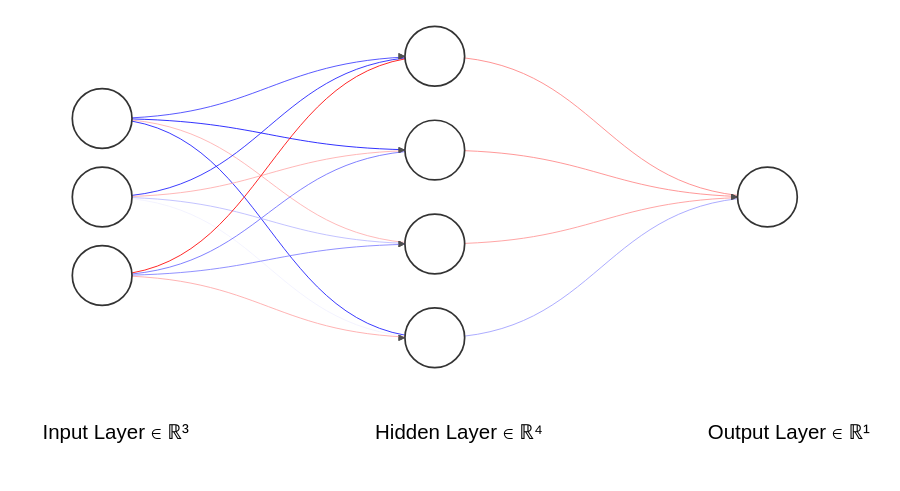

или ещё побольше

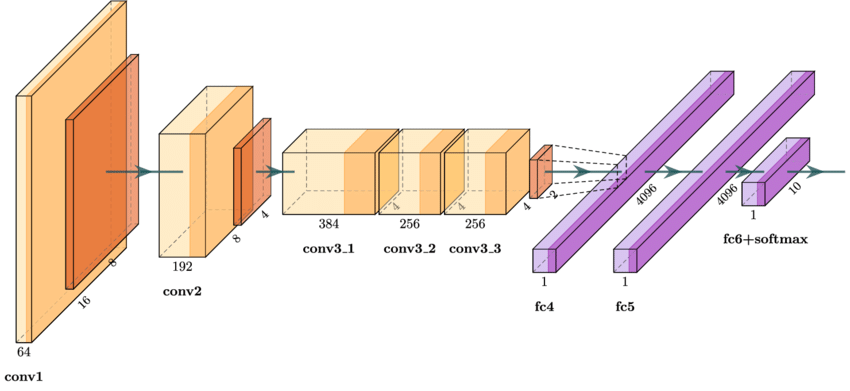

то нам нужно решить две задачи:
- Реализовать много дополнительх строительных блоков
- Сделать наши строительные блоки более универсальными и масштабируемыми

Первый путь их решения - написать каждый модуль вручную в виде совместимых друг с другом классов. Это довольно муторный и неблагодарный путь, который всё равно не позволит достичь достаточной гибкости, необходимой для построения и поддержки действительно больших моделей:

In [14]:
class Linear:

    def __init__(self, in_features, out_features, bias=True):
        
        # Магия инициализации
        pass


    def process_hooks(self):

        # Магия обработки взаимодействия с другими блоками нашей сети
        pass


    def __call__(self, X):

        # Магия обработки взаимодействия с другими блоками нашей сети
        self.process_hooks()

        return self.forward(X)


    def update_weights(self, ):

        # Обновление весов
        pass


    def backward(self):

        # Расчёт градиентов
        return grad
        
    
    def forward(self, X):


        return outp


class Sigmoid:

    # ....

    # ....

    def forward(self):
        pass
    

# и ещё куча подобного кода, который трудно поддерживать и модифицировать


Второй путь - рассмотреть каждый блок нейросети как чёрный ящик.

Устройство этого ящика для нас не важно - важно, чтобы он умел делать следующие вещи:
- Выполнял некоторое преобразование матриц, зависящее от его внутреннего состояния;
- Должен уметь передавать градиент дальше по цепочке;
- Позволяет итерироваться по своим параметрам и подулям
- ...

Раз мы знаем универсальные методы, которые должны быть у нашего строительного блока будет много, можно задействовать классовую абстракцию:


In [15]:
# Псевдокод класса nn.Module и его наследников

from abc import ABC, abstractmethod


class Module(ABC):

    def __init__(self):

        pass

    @abstractmethod
    def forward() -> torch.Tensor:

        pass

    
    def backward() -> torch.Tensor:

        return
    
    # и прочее ...
    
    
class Linear(Module):

    def __init__(self):

        pass


    def forward(self):

        pass




Модуль torch.nn предоставляет большой набор готовых модулей и других рутин, очень малую часть которых мы рассмотрели выше. 

Их описания всегда можно прочитать здесь: https://pytorch.org/docs/stable/nn.html

А исходный код - здесь: https://github.com/pytorch/pytorch/tree/main/torch/nn

Самый важный класс этого модуля - `torch.nn.Module()`. Это намного более продуманная реализация нашего "черного ящика" для элементарного блока нейросети. Все строительные блоки в PyTorch являются наследниками этого класса, и мы напишем несколько своих.

Перечислим некоторые полезные методы, определяемые этим классом:
- `__call__()` - стандартный метод для применения модуля к каким-либо данным. На самом деле реализуется не через magic-метод, но для нас это не особо важно.
- `apply()` - рекурсивно применить функцию к модулю и всем его подмодулям. 
- `to()` - 
- `eval()`, `train()` - переключают режимы работы модуля(позже разберём подробнее);
- `device()`, `cpu()`, `cuda()`, `ipu()`, `xpu()`, `mtia()` - перемещение модуля между платформами;
- `load_state_dict()` - загружает состояние модели;
- `state_dict()` - возвращает (или записывает в файл) словарь, описывающий состояния модуля (и подмодулей);
- `children()` - возвращает итератор по всем _непосредственным_ дочерним модулям;
- `modules()` - возвращает итератор по всем подмодулям;
- `parameters()` - возвращает итератор по всем параметрам всех подмодулей;
- `zero_grad()` - обнуляет градиенты всех параметров;
- `compile()` - компилирует forward метод этого модуля в машинный код с помощью `torch.compile`

Прелесть `pytorch` в том, что единственное, что нужно определить в модуле нейросети, чтобы он начал работать - инициализацию параметров и функцию `forward`

Таким образом, единственное, что нужно определить, чтобы наш  модуль нейросети начал работать - написать инциализацию параметров и само преобразование, выполняемое модулем.

И конечно, сами нейросети на `pytorch` тоже являются наследниками `nn.Module`.

Широкий функционал класса `Module` строится, в том числе, на двух новых базовых классах для хранения параметров. Все они являются подклассами класса `Tensor` и расширяют его функционал.

Класс `Parameter`: это класс, хранящий веса или любые другие параметры модуля. Такие веса будут обновляться на каждом шаге градиентного спуска.

Класс `Buffer`: это специальный класс, который полезен для хранения данных внутри модуля. Записанные в него данные не будут считаться весами и не будут обновляться на обратном проходе (если вы не напишете этот функционал вручную). Например, такие параметры используются в BatchNorm слоях для хранения средних значений.

Аналогичного поведения можно добиться от тензоров с помощью встроенного метода `nn.Module.register_buffer()`.


In [16]:
## Пример:

tensor_a = torch.randn((3, 4, 5))

param_a = nn.Parameter(tensor_a)
print(param_a)


buffer_a = nn.Parameter(tensor_a)
print(buffer_a)

Parameter containing:
tensor([[[ 0.7958, -0.0448,  0.7671,  2.0942,  1.0224],
         [ 1.4510, -0.4533,  0.0855,  0.3066, -0.3586],
         [-0.2022,  2.3889, -1.3143, -2.0878, -0.3266],
         [-0.5643, -1.6163,  1.4197,  0.4785,  0.9246]],

        [[-1.7282,  0.1675,  0.6428, -0.6871, -0.4912],
         [ 1.6767,  0.1578, -0.6700, -0.0593, -1.0045],
         [ 1.0817,  1.4682,  0.3466, -0.3788,  1.9452],
         [-0.8413, -0.7700, -0.3985, -1.4533,  1.0531]],

        [[ 0.0870, -0.4251,  0.3150,  2.0885,  0.8683],
         [-0.1955, -0.1189,  0.3515, -0.8572, -0.1101],
         [ 0.6401,  0.6760,  0.3986,  1.5125,  0.4025],
         [ 0.2287, -0.3458, -0.7341,  0.0123,  1.3069]]], requires_grad=True)
Parameter containing:
tensor([[[ 0.7958, -0.0448,  0.7671,  2.0942,  1.0224],
         [ 1.4510, -0.4533,  0.0855,  0.3066, -0.3586],
         [-0.2022,  2.3889, -1.3143, -2.0878, -0.3266],
         [-0.5643, -1.6163,  1.4197,  0.4785,  0.9246]],

        [[-1.7282,  0.1675,  0.6

In [ ]:
## Задача: реализуйте полносвязный блок

class my_Linear(nn.Module):

    def __init__(self, in_features, out_features, bias=True):

        super().__init__()

        # YOUR CODE
    
        pass



In [ ]:
## Задача: создайте свою функцию активации

class my_Sigmoid(nn.Module):

    def __init__(self):
        
        # YOUR CODE

        pass
        

    def forward(self, X) -> torch.Tensor:

        # YOUR CODE

        return outp
    

In [19]:
# Протестируем с помощью модуля Unittest:
import unittest

class TestLayers(unittest.TestCase):

    def setUp(self):

        self.linear_constructor = my_Linear
        self.activation_constructor = my_Sigmoid


    def test_Linear(self):

        test_cases = [\
            {'in': 1, 'out':1, 'bias': True},
            {'in': 10, 'out':5, 'bias': False},
            {'in': 100, 'out':10, 'bias': True}
        ]
        batch_size = 1

        for tst in test_cases:

            L1 = self.linear_constructor(
                in_features=tst['in'],
                out_features=tst['out'],
                bias=tst['bias']
                )
            
            if tst['bias']:

                test_inp = torch.randn((batch_size, tst['in']))
                
                exp_shape = torch.zeros((batch_size, tst['out'])).shape

                outp = L1(test_inp)

                self.assertTrue(
                    outp.shape == exp_shape,
                    'Output shape {} does not match expected {}'.format(outp.shape, exp_shape))
                
                self.assertTrue(
                    outp.requires_grad,
                    'Gradients are not attached to output')
   
            else:

                test_inp = torch.zeros((batch_size, tst['in']))
                
                exp_out = torch.zeros((batch_size, tst['out']))

                outp = L1(test_inp)

                self.assertFalse(
                    outp.shape == exp_shape,
                    'Output shape {} does not match expected {}'.format(outp.shape, exp_out.shape))

                self.assertTrue(
                    torch.allclose(outp, exp_out, atol=1e-3, rtol=1e-3),
                    'Without bias, only zeros should be on output')
                
                self.assertTrue(
                    outp.requires_grad,
                    'Gradients are not attached to output')
   
    
    def test_Activation(self):

        test_cases = [\
            {'in': (1)},
            {'in': (10)},
            {'in': (10, 10)}
            ]

        S1 = self.activation_constructor()
        S2 = nn.Sigmoid()

        for tst in test_cases:

            test_inp = torch.randn(tst['in'])

            outp_1 = S1(test_inp)
            outp_2 = S2(test_inp)

            self.assertTrue(\
                torch.allclose(outp_1, outp_2, rtol=1e-3,atol=1e-3),
                'Output mismatch with built-in pytorch Sigmoid'
                )

        

unittest.main(argv=[''], verbosity=2, exit=False)

test_Activation (__main__.TestLayers.test_Activation) ... ok
test_Linear (__main__.TestLayers.test_Linear) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.005s

OK


In [20]:
## Пройдёмся по части перечисленного функционала и убедимся,
## что наши модули унаследовали атрибуты и методы nn.Module()

model_a = nn.Sequential(\
    my_Linear(1, 1),
    my_Sigmoid()
)

print("Modules:")

for module in model_a.modules():
    print('--------')
    print(module)
    print(module.state_dict())
print('========\n')

print(model_a.state_dict())

Modules:
--------
Sequential(
  (0): my_Linear()
  (1): my_Sigmoid()
)
OrderedDict({'0.w': tensor([[1.2641]]), '0.bias': tensor([-0.2419])})
--------
my_Linear()
OrderedDict({'w': tensor([[1.2641]]), 'bias': tensor([-0.2419])})
--------
my_Sigmoid()
OrderedDict()

OrderedDict({'0.w': tensor([[1.2641]]), '0.bias': tensor([-0.2419])})


Из готовых блоков, на данном этапе нам будут полезны:

- nn.Linear
- nn.Sigmoid, nn.Tanh, nn.Relu и другие активации

Модуль `torch.nn`, кроме прочего, определяет множество функций ошибки.

Благодаря магии автоматического дифференцирования, функцию ошибки достаточно просто определить - как обычный метод или лямбда-выражение:

In [21]:
my_MSE = lambda Y, Y_p: sum((Y-Y_p)**2)

X_prob = torch.randn((10, 1))
y_prob = torch.randn((10, 1))
y_pred = model_a(X_prob)

loss = my_MSE(y_pred, y_prob)
print(loss)

loss.backward()

tensor([12.3214], grad_fn=<AddBackward0>)


# Модуль `torch.optim`

Теперь рассмотрим процесс оптимизации как чёрный ящик... ну, вы понимаете, к чему мы идём.

Все процедуры, применяемые при обучении сети методом стохастического градиентного спуска, могут и должны быть обобщены. Это первоклассно реализовано в модуле `torch.optim`.

Подробно разбирать этот модуль не будем, только рассмотрим минимальный пример оптимизатора на нашей задаче о градуснике:

In [ ]:
from torch.optim import Optimizer


class CustomGradientDescent(Optimizer):

    def __init__(self, params, lr=0.01):
        

        defaults = {'lr': lr}
        super(CustomGradientDescent, self).__init__(params, defaults)


    def step(self, closure=None):
        '''
        Шаг оптимизации.
        '''
        
        for group in self.param_groups:
            lr = group['lr']
            for param in group['params']:

                # Если градиента нет, пропускаем
                if param.grad is None:
                    continue

                # В остальных случаях делаем шаг градиентного спуска
                param.data = param.data - lr * param.grad.data


In [26]:
## Создадим модель на основе наших классов и применим к ней:

class ThermometerModel(nn.Module):

    def __init__(self):

        super().__init__()
        self.L1 = my_Linear(1,1)


    def forward(self, X):

        outp = self.L1(X)

        return outp


model = ThermometerModel()

# Определим функцию ошибки

criterion = torch.nn.MSELoss()

# Подготовим данные
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c).view(-1, 1)
t_u = torch.tensor(t_u).view(-1, 1)



# Создадим оптимизатор
optimizer = CustomGradientDescent(model.parameters(), lr=1e-4)

# Цикл обучения:
for epoch in range(100):
    
    # Переводим модель в режим обучения
    model.train()

    # Обнуляем градиенты
    optimizer.zero_grad()

    # Прямое распространениеa
    t_pred = model(t_u)
    
    # Считаем ошибку и делаем обратное распространение
    loss = criterion(t_pred, t_c)  
    loss.backward()      

    # Обновляем веса
    optimizer.step()

    # Выводим ошибку на эпохе:
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


Epoch 0, Loss: 13097.6279296875
Epoch 10, Loss: 26.25529670715332
Epoch 20, Loss: 26.24687385559082
Epoch 30, Loss: 26.238710403442383
Epoch 40, Loss: 26.23054313659668
Epoch 50, Loss: 26.222383499145508
Epoch 60, Loss: 26.2142276763916
Epoch 70, Loss: 26.206073760986328
Epoch 80, Loss: 26.197919845581055
Epoch 90, Loss: 26.189775466918945


# Задача: предсказание чисел Вольфа

Числа Вольфа - это качественный показатель солнечной активности, связанный с количеством солнечных пятен. 

Официально числа Вольфа регистрируются Цюрихской обсерваторией с 1849 года, но восстанавливают и более ранние данные - в нашем случае отсчёт будет идти с 1818 года.

Наша задача - научить полносвязную нейросеть предсказывать этот _временной ряд_.

Напомню, что временной ряд - это последовательность точек данных (в данном случае - количества пятен на Солнце), разделённая равными временными интервалами.

Одна из стандартных методик предсказания временных рядов - экстраполяция, т.е. предсказание следующих данных на основе предыдущих.

В случае нейросетей методика следующая:
- Задают размер окна данных, на основе которого делается предсказание;
- Нейросеть учится на всех возможных окнах несколько эпох;
- Профит!


In [ ]:
## Задание 1: Загрузите и изучите данные

data_path = root_path + '/data/ISSN_D_tot.csv'

# Filename: ISSN_D_tot.csv
# Contents:
# Column 1-3: Gregorian calendar date
# - Year
# - Month
# - Day
# Column 4: Date in fraction of year
# Column 3: Daily total sunspot number. A value of -1 indicates that no number is available for that day (missing value).
# Column 4: Definitive/provisional indicator. '1' indicates that the value is definitive. '0' indicates that the value is still provisional and is subj


# YOUR CODE


# Нам понадобится только колонка "VAL"

data = sol_df['VAL'].to_numpy()
print(type(data))
data = torch.FloatTensor(data)
print(type(data), data.dtype)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72104 entries, 0 to 72103
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   YYYY    72104 non-null  int64  
 1   MM      72104 non-null  int64  
 2   DD      72104 non-null  int64  
 3   YEARF   72104 non-null  float64
 4   VAL     72104 non-null  int64  
 5   I       72104 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 3.3 MB
None
YYYY     0
MM       0
DD       0
YEARF    0
VAL      0
I        0
dtype: int64
       YYYY  MM  DD     YEARF  VAL  I
54230  1966   6  24  1966.478   66  1
41046  1930   5  20  1930.382   39  1
61369  1986   1   9  1986.023    0  1
65641  1997   9  20  1997.719   14  1
23912  1883   6  21  1883.472   85  1
63173  1990  12  18  1990.962  121  1
63521  1991  12   1  1991.915  102  1
5230   1832   4  27  1832.323   19  1
50678  1956  10   2  1956.753  183  1
61156  1985   6  10  1985.440   58  1
<class 'numpy.ndarray'>
<class 'torch.Tensor

In [ ]:
# Задание 2: Напишите класс TimeseriesLoader
# для создания генераторов пар (x_window, y_pred)
# На основе наших данных

class TimeseriesLoader():

    def __init__(self, data: torch.Tensor, lookback, fwd_scope=1, stride=1):


        # YOUR CODE


    def __iter__(self):

        # YOUR CODE



    def __next__(self):

        # YOUR CODE



## Тестируем:
A = torch.randn((8, 2))

loader = TimeseriesLoader(A, 2, 2, 1)

for d in loader:
    print(d)



(tensor([[-0.1641, -0.5683],
        [-0.6005,  0.0480]]), tensor([[-1.0771, -0.1070],
        [ 1.2604,  0.0956]]))
(tensor([[-0.6005,  0.0480],
        [-1.0771, -0.1070]]), tensor([[ 1.2604,  0.0956],
        [-0.3636, -1.2536]]))
(tensor([[-1.0771, -0.1070],
        [ 1.2604,  0.0956]]), tensor([[-0.3636, -1.2536],
        [-0.2318,  1.6098]]))
(tensor([[ 1.2604,  0.0956],
        [-0.3636, -1.2536]]), tensor([[-0.2318,  1.6098],
        [-0.2610,  1.3937]]))


In [41]:
# Сгенерируeм наборы окон из данных с помощью TimeseriesLoader()

LOOKBACK = 20
FWD_SCOPE = 1

loader = TimeseriesLoader(data, lookback=LOOKBACK, fwd_scope=FWD_SCOPE, stride=1)
time_frames = [frame for frame in loader]
print(len(time_frames))
print(time_frames[0])
print(time_frames[200])

X_train = torch.stack([frame[0] for frame in time_frames])
y_train = torch.stack([frame[1] for frame in time_frames])

print(X_train.shape)
print(y_train.shape)

72083
(tensor([-1., -1., -1., -1., -1., -1., -1., 39., -1., -1., -1., -1., 22., -1.,
        -1., -1., 46., 59., 63., -1.]), tensor([-1.]))
(tensor([16., -1., -1., 31., 46., -1., 38., 52., 30., -1., 31., -1., -1., 28.,
        17., 10., 10., 13., 19., 38.]), tensor([35.]))
torch.Size([72083, 20])
torch.Size([72083, 1])


In [ ]:
## Задание 3: Напишите класс модели.
## Реализуйте методы __init__ и forward

# YOUR CODE



## Тестируем:

lookback = 4
scope = 3
batch_size = 2

X_try = torch.randn(batch_size, lookback)

model_P = SeriesPredictor(lookback=lookback, scope=scope)

# Если всё нормально, у предсказанного тензора будет градиент,
# а сам он будет иметь форму [batch_size, scope]
y_pred = model_P.forward(X_try)
print(y_pred)
print(y_pred.shape)



tensor([[-0.6248, -0.1744, -0.0338],
        [-0.6201, -0.1703, -0.0286]], grad_fn=<AddmmBackward0>)
torch.Size([2, 3])


In [ ]:
## Задание 4: реализуйте train_loop и обучите модель

# Train loop:

def train_loop(model, loss, sampler, optimizer, n_epochs=30):
    
    # YOUR CODE
   


# Все вызовы для обучения:
from impls import BatchSampler

# YOUR CODE



train_loop(model=model,
        loss=loss,
        sampler=sampler,
        optimizer=optimizer,
        n_epochs=10)


Epoch 0, Loss: 2251.39306640625
Epoch 1, Loss: 1974.3426513671875
Epoch 2, Loss: 1753.677978515625
Epoch 3, Loss: 1647.7049560546875
Epoch 4, Loss: 1691.6627197265625
Epoch 5, Loss: 1628.2994384765625
Epoch 6, Loss: 1542.2181396484375
Epoch 7, Loss: 1650.2764892578125
Epoch 8, Loss: 1793.9859619140625
Epoch 9, Loss: 1728.4219970703125
